In [79]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_validate,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    RocCurveDisplay,
    confusion_matrix,
    check_scoring
)

from functools import reduce
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib

In [7]:
# initial dataframe from the cleaned data in silver layer


silver_path = Path.cwd().parent / 'data' / 'silver' / 'creditcard_fraud_cleaned.parquet'

df = pd.read_parquet(silver_path)
print('the shape of this df should be exactly: (283726, 31)\nshape: ', df.shape)
df.head(3)

the shape of this df should be exactly: (283726, 31)
shape:  (283726, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [8]:
# splitting dataset in X(independent features) and y (target class)

X = df.drop(columns='class')
y = df['class']
(y.value_counts()/y.shape[0])*100

class
0    99.83329
1     0.16671
Name: count, dtype: float64

In [9]:
# all the dataset is already scaled with pca transform, except for time and amount
# so before splitting and training the dataset,let's scale:
# time using minMaxscaler, which is standard
# amount using robustScaler, to better treat the significant rigth skewness and outliers


time_scaler = MinMaxScaler()
amount_scaler = RobustScaler()
X['time_scaled'] = time_scaler.fit_transform(X[['time']])
X['amount_scaled'] =amount_scaler.fit_transform(X[['amount']])
X[['amount_scaled','time_scaled']].describe()

,amount_scaled,time_scaled
count,283726.000000,283726.000000
mean,0.924387,0.548701
std,3.482123,0.274787
min,-0.305938,0.000000
25%,-0.228063,0.313699
50%,0.000000,0.490141
75%,0.771937,0.806160
max,356.962314,1.000000


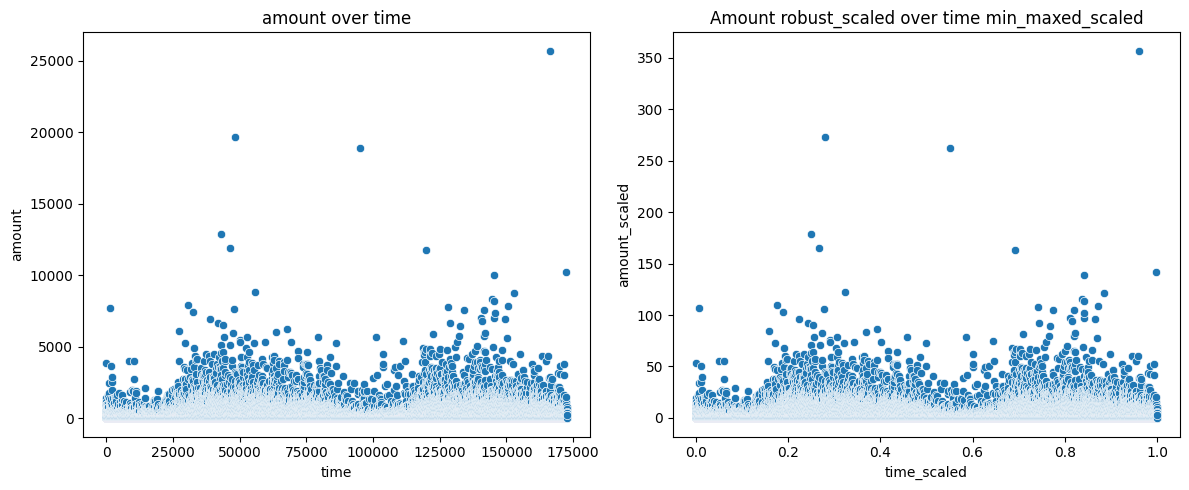

In [ ]:
#showing that scalling these features does not lose any information
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# normal time plot
sns.scatterplot(data = X, x='time', y='amount', ax=axes[0])
axes[0].set_title('amount over time')

# Right plot
sns.scatterplot(data = X, x='time_scaled', y='amount_scaled', ax=axes[1])
axes[1].set_title('Amount robust_scaled over time min_maxed_scaled')


plt.tight_layout()
plt.show()


In [ ]:
# splitting the data in training and testing, using stratify to keep the proportions and not bias the data

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=11037)

In [22]:
# preparing the training data (and keeping test data equivalent)
X_train = X_train.drop(columns=['time','amount'])
X_test = X_test.drop(columns=['time','amount'])
X_train.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,time_scaled,amount_scaled
95756,-0.824643,-0.380659,1.406608,-1.973115,-1.670249,-0.374518,-0.855799,0.399257,-2.146896,0.800051,...,-0.133007,-0.261955,-0.049717,-0.174729,-0.330425,-0.320548,-0.063222,0.004724,0.379751,0.671673
238490,2.032145,-0.052669,-1.438417,0.136430,0.314567,-0.551100,0.093281,-0.147471,0.298596,0.164153,...,0.299837,0.972306,0.032060,0.744726,0.243748,-0.159219,-0.024080,-0.061866,0.868536,-0.293561
20111,1.308316,-0.803327,1.074024,-0.679719,-1.671284,-0.557354,-1.200662,0.136785,-0.485938,0.811140,...,0.435025,1.105527,-0.078697,0.545394,0.326508,-0.075536,0.025270,0.015780,0.178475,-0.083577


In [11]:
# lets check the data splitting (this could be a function in the ML pipeline) (still simillar proportion)
print('how many frauds and non frauds in the test split\n',y_train.value_counts())
print()
print((y_train.value_counts()/y_train.shape[0])*100)

how many frauds and non frauds in the test split
 class
0    226602
1       378
Name: count, dtype: int64

class
0    99.833466
1     0.166534
Name: count, dtype: float64


## 🧠 Why Logistic Regression for the Baseline?
Logistic Regression is a simple, interpretable model that gives us a **baseline** for detecting fraud.
It's useful for benchmarking because:

- It requires minimal hyperparameter tuning.
- Its coefficients can indicate feature importance.
- However, **Logistic Regression is sensitive to feature scaling**, so we preprocess `time` and `amount`.

---

## ⚠️ Class Imbalance in Fraud Detection
The dataset is **highly imbalanced**:
- Class 0 (Non-Fraud): 99.833%
- Class 1 (Fraud): 0.167%

This means **accuracy** is a **bad metric** (a model predicting "no fraud" every time would still be right 99.8% of the time). Instead, we use metrics that focus on the minority class.

---

## 📏 Key Metrics for Imbalanced Data
| Metric            | Why It Matters                                                        |
|--------------------|------------------------------------------------------------------------|
| **Precision**      | Of all predicted fraud cases, how many were correct?                 |
| **Recall (Sensitivity)** | Of all actual fraud cases, how many did we detect?                  |
| **F1-score**       | Harmonic mean of Precision and Recall (balances false positives and negatives). |
| **ROC AUC**        | Measures model's ability to separate classes across thresholds.      |
| **PR AUC**         | Precision-Recall AUC focuses on the minority class (more informative for imbalanced data). |
| **Balanced Accuracy** | Adjusts accuracy to account for class imbalance.                  |

We’ll compute all of these using cross validate and stratified k-fold.

In [207]:
# as this is a binary classification problem (it has two classes, positive, fraud, and negative, non-fraud)
# a logistic classifier is more apropriate

log_clf = LogisticRegression(class_weight='balanced',random_state=11037, max_iter=400)

In [180]:
# define scorers
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',  # threshold=0.5
    'recall': 'recall',        # threshold=0.5
    'f1': 'f1',                # threshold=0.5
    'roc_auc': 'roc_auc',      # needs probabilities for it to be based on all threshold
    'pr_auc': 'average_precision',  # needs probabilities
    'balanced_accuracy': 'balanced_accuracy',
}

In [181]:
# define stratified CV to preserve fraud/non-fraud ratio in all folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11037)

In [184]:
# perform cross-validation
cv_results = cross_validate(
    log_clf,
    X_train, y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,

)
results_df = pd.DataFrame(cv_results).mean()

In [185]:
results_df

fit_time                  1.216507
score_time                0.049445
test_accuracy             0.975641
test_precision            0.058549
test_recall               0.902211
test_f1                   0.109942
test_roc_auc              0.969993
test_pr_auc               0.710238
test_balanced_accuracy    0.938987
dtype: float64

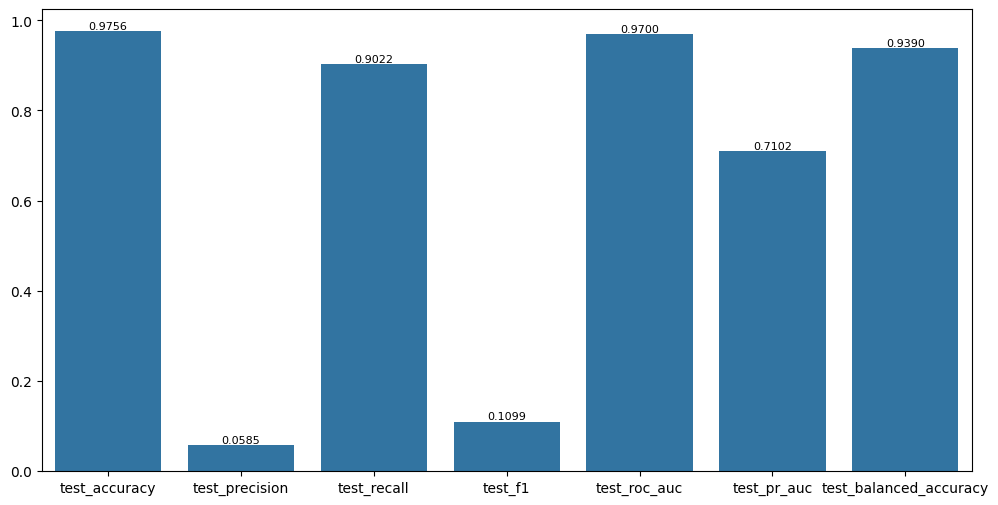

In [186]:
plt.figure(figsize=(12,6))
base_model_scores_barplot = sns.barplot(results_df.loc['test_accuracy':])


for patch in base_model_scores_barplot.patches:
    height = patch.get_height()
    if height > 0:
        base_model_scores_barplot.annotate(f'{height:.4f}',  # formatting
            (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
            ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center


plt.show()

In [208]:
log_clf.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,11037
,solver,'lbfgs'
,max_iter,400
,multi_class,'deprecated'


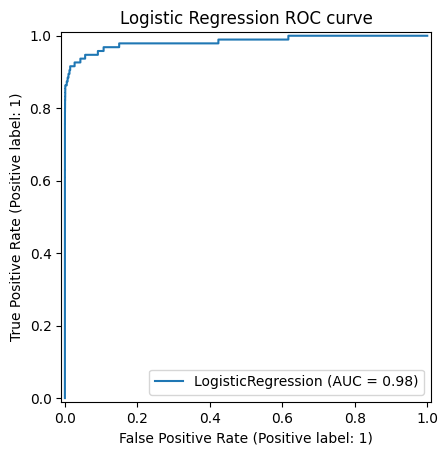

In [209]:
RocCurveDisplay.from_estimator(log_clf, X_test, y_test)
plt.title('Logistic Regression ROC curve')
plt.show()

In [191]:
y_pred_log_clf = log_clf.predict(X_test)

[[55294  1357]
 [    8    87]]


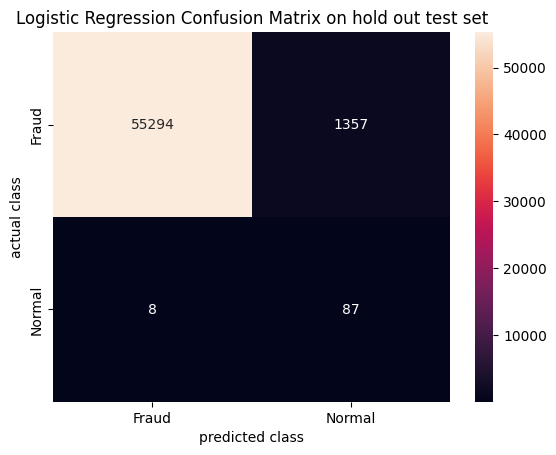

In [210]:
plot_confusion_matrix(y_pred_log_clf, y_test, 'Logistic Regression Confusion Matrix on hold out test set')

In [211]:
# saving the baseline model

file_path = Path.cwd().parent / 'models' / 'logistic_regression_baseline.pkl'
joblib.dump(log_clf, file_path)

print('model succesfully saved in', file_path)

model succesfully saved in e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\models\logistic_regression_baseline.pkl


# Lets remember the features most correlated to target class (fraud)
this will be the base for:

feature selection

feature engineering

feature dropping

In [74]:
# 📊 Correlation with target
correlations = X_train.copy()
correlations['target'] = y_train

corr_matrix = correlations.corr()
target_corr = corr_matrix['target'].drop('target').sort_values(key=abs, ascending=False)

# Display sorted correlations
target_corr


v17             -0.311266
v14             -0.293491
v12             -0.249222
v10             -0.203651
v16             -0.186174
v3              -0.179066
v7              -0.168170
v11              0.148381
v4               0.128249
v18             -0.103904
v9              -0.092236
v1              -0.090789
v5              -0.084364
v2               0.083933
v6              -0.044503
v8               0.034168
v19              0.032724
v21              0.029664
v27              0.023932
v20              0.021515
time_scaled     -0.012050
v28              0.010386
v24             -0.007987
v23             -0.005966
amount_scaled    0.005585
v13             -0.004188
v26              0.003607
v22              0.003062
v15             -0.002705
v25              0.002597
Name: target, dtype: float64

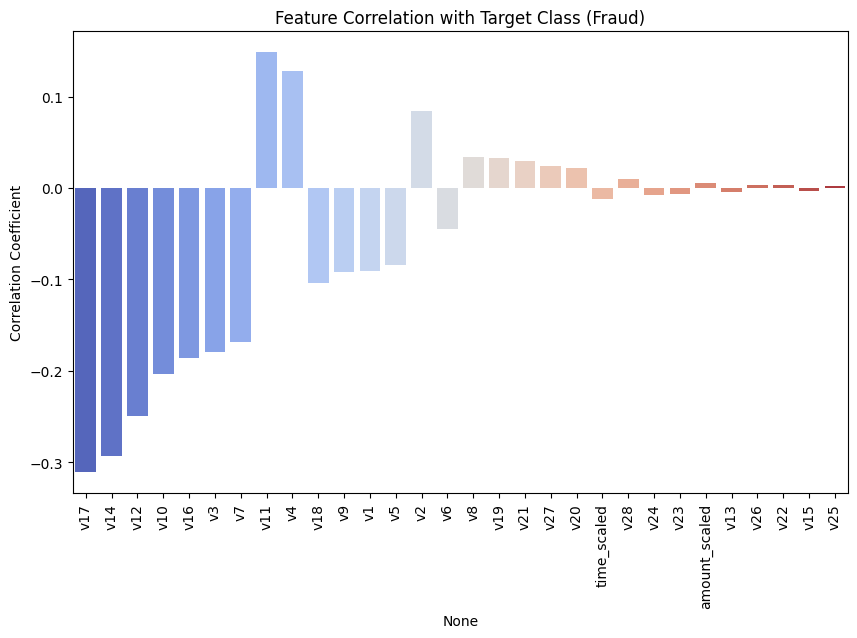

In [75]:
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values,hue=target_corr.index,legend=False, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Feature Correlation with Target Class (Fraud)")
plt.ylabel("Correlation Coefficient")
plt.show()

In [ ]:


used_features = []
scores = []

for f in target_corr.index:
    used_features.append(f)

    log_temp = LogisticRegression(class_weight='balanced', max_iter=400, random_state=11037)

    # 5-fold CV and F1 score (for imbalance)
    cv_scores = cross_val_score(
        log_temp,
        X_train[used_features],
        y_train,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )

    mean_score = cv_scores.mean()
    scores.append(mean_score)

    print(f"Added Feature: {f} | F1-Score: {mean_score:.4f}")


Added Feature: v17 | F1-Score: 0.5733
Added Feature: v14 | F1-Score: 0.1258
Added Feature: v12 | F1-Score: 0.1144
Added Feature: v10 | F1-Score: 0.1207
Added Feature: v16 | F1-Score: 0.1223
Added Feature: v3 | F1-Score: 0.1173
Added Feature: v7 | F1-Score: 0.1195
Added Feature: v11 | F1-Score: 0.1179
Added Feature: v4 | F1-Score: 0.1121
Added Feature: v18 | F1-Score: 0.1103
Added Feature: v9 | F1-Score: 0.1105
Added Feature: v1 | F1-Score: 0.1099
Added Feature: v5 | F1-Score: 0.1042
Added Feature: v2 | F1-Score: 0.1039
Added Feature: v6 | F1-Score: 0.1062
Added Feature: v8 | F1-Score: 0.1099
Added Feature: v19 | F1-Score: 0.1126
Added Feature: v21 | F1-Score: 0.1111
Added Feature: v27 | F1-Score: 0.1120
Added Feature: v20 | F1-Score: 0.1126
Added Feature: time_scaled | F1-Score: 0.1157
Added Feature: v28 | F1-Score: 0.1166
Added Feature: v24 | F1-Score: 0.1167
Added Feature: v23 | F1-Score: 0.1138
Added Feature: amount_scaled | F1-Score: 0.1152
Added Feature: v13 | F1-Score: 0.1190
Add

## 🔍 Forward Feature Selection with Logistic Regression

To explore the contribution of individual features to model performance, we performed a forward feature selection procedure. At each step, we added the next most-correlated feature to the model and computed the mean F1-score using 5-fold cross-validation.

The results show:

- The first feature alone achieves a very high F1-score (~0.65).
- Adding additional features leads to a sharp performance drop and does not improve results significantly.
- This suggests that the first feature captures most of the fraud signal for a linear model like Logistic Regression.

This behavior is expected because:
- Most features are PCA-transformed and orthogonal, meaning they are uncorrelated by construction.
- Logistic Regression may struggle to separate classes in PCA space.

The plot below illustrates this trend.


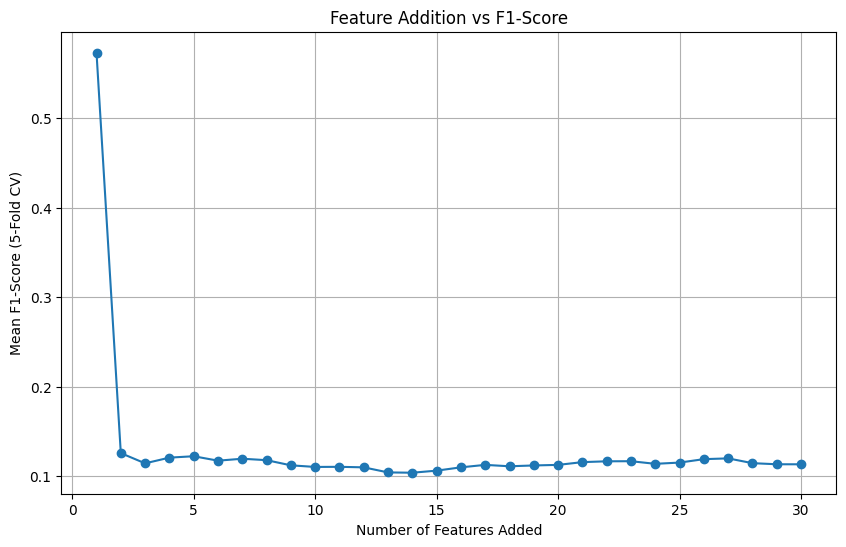

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.title("Feature Addition vs F1-Score")
plt.xlabel("Number of Features Added")
plt.ylabel("Mean F1-Score (5-Fold CV)")
plt.grid(True)
plt.show()

In [154]:
log_v17_clf = LogisticRegression(class_weight='balanced', max_iter=400, random_state=11037)
# perform cross-validation with full metrics on v17 only
cv_v17_results = cross_validate(
    log_v17_clf,
    X_train[['v17']], y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False
)
results_v17_series = pd.DataFrame(cv_v17_results).mean()

In [162]:
def correct_names_after_cv(cv_results_series):
    corrected_names = []
    for index in cv_results_series.index:
        if index.startswith('test_'):
            index = index.removeprefix('test_')
            corrected_names.append(index)
        else:
            corrected_names.append(index)

    cv_results_series.index = corrected_names


In [164]:
correct_names_after_cv(results_v17_series)
results_v17_series

fit_time             0.104495
score_time           0.037434
accuracy             0.998277
precision            0.490361
recall               0.709123
f1                   0.579012
roc_auc              0.798603
pr_auc               0.587787
balanced_accuracy    0.853941
dtype: float64

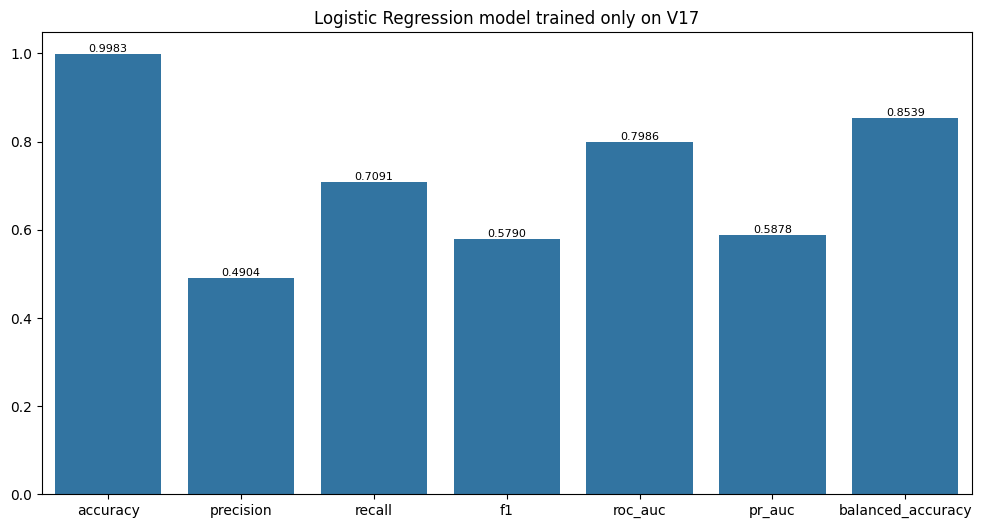

In [165]:
def plot_bar_metrics(score_df: pd.DataFrame, title='placeholder'):
    plt.figure(figsize=(12,6))
    model_scores_barplot = sns.barplot(score_df.loc['accuracy':])


    for patch in model_scores_barplot.patches:
        height = patch.get_height()
        if height > 0:
            model_scores_barplot.annotate(f'{height:.4f}',  # formatting
                (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
                ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center

    plt.title(title)
    plt.show()

plot_bar_metrics(results_v17_series, 'Logistic Regression model trained only on V17')

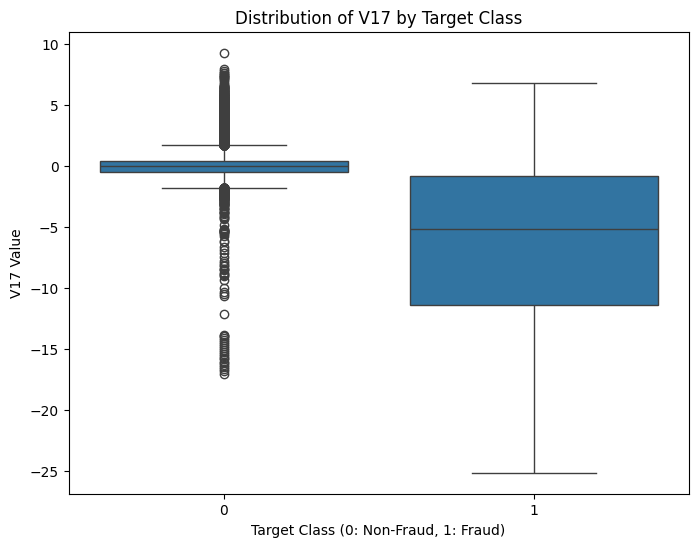

In [18]:


plt.figure(figsize=(8, 6))
sns.boxplot(x=y_train, y=X_train['v17'])
plt.title("Distribution of V17 by Target Class")
plt.xlabel("Target Class (0: Non-Fraud, 1: Fraud)")
plt.ylabel("V17 Value")
plt.show()

In [31]:
# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",  # Binary classification
    eval_metric="aucpr",          # PR AUC for imbalanced data
    scale_pos_weight=10,          # imbalance adjustment
    random_state=11037,
    n_jobs=-1                     # use all cores
)

cv_results = cross_validate(
    xgb_clf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Print mean scores
for metric, scores in cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.4f}")


test_accuracy: 0.9996
test_precision: 0.9263
test_recall: 0.7964
test_f1: 0.8562
test_roc_auc: 0.9769
test_pr_auc: 0.8435
test_balanced_accuracy: 0.8982


In [32]:


# Parameter grid
param_dist = {
    'n_estimators': [100, 300, 500, 750],
    'max_depth': [3, 6, 10, None],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6,0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 10, 50]  # imbalance adjustment
}

# Randomized Search
xgb_random = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,                # test 20 random combinations
    scoring='average_precision',  # optimize PR AUC
    cv=cv,                     
    verbose=1,
    random_state=11037,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train )

print("Best parameters found:", xgb_random.best_params_)
print("Best PR AUC score:", xgb_random.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:50:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found: {'subsample': 0.7, 'scale_pos_weight': 10, 'n_estimators': 500, 'max_depth': None, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best PR AUC score: 0.8527305043438291


⚠️ **Note on Hyperparameter Boundaries**
When RandomizedSearchCV selects a parameter at the boundary of the search space, it suggests that a better value may lie beyond the current range. To address this, we expanded the grid for that parameter and reran the search, carefully monitoring for overfitting.


In [35]:


bst_clf = xgb.XGBClassifier(
    **xgb_random.best_params_,
    random_state=11037,
    n_jobs=-1
)


In [36]:
bst_clf = bst_clf.fit(X_train,y_train)

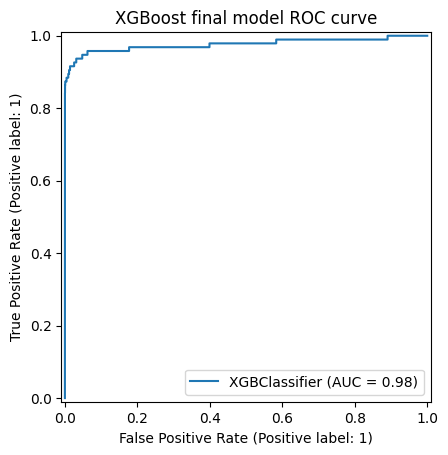

In [74]:
RocCurveDisplay.from_estimator(bst_clf, X_test, y_test)
plt.title('XGBoost final model ROC curve')
plt.show()v

[[56645     6]
 [   18    77]]


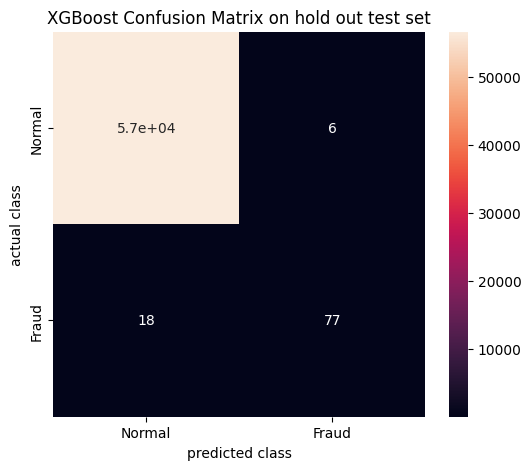

In [89]:
y_pred_bst_clf = bst_clf.predict(X_test)
final_model_cm = confusion_matrix(y_test,y_pred_bst_clf)

# sns.heatmap(final_model_cm,annot=True)


labels = ['Normal', 'Fraud']
plt.figure(figsize=(6, 5))
ax = sns.heatmap(final_model_cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.title('XGBoost Confusion Matrix on hold out test set')
plt.xlabel('predicted class')
plt.ylabel('actual class')
print(final_model_cm)

In [37]:
scoring_call = check_scoring(estimator=bst_clf, scoring=scoring, raise_exc=False)
bst_clf_scores = scoring_call(bst_clf, X_test, y_test)

In [67]:


bst_clf_scores_series = pd.Series(bst_clf_scores)
bst_clf_scores_series

accuracy             0.999577
precision            0.927711
recall               0.810526
f1                   0.865169
roc_auc              0.976215
pr_auc               0.860535
balanced_accuracy    0.905210
dtype: float64

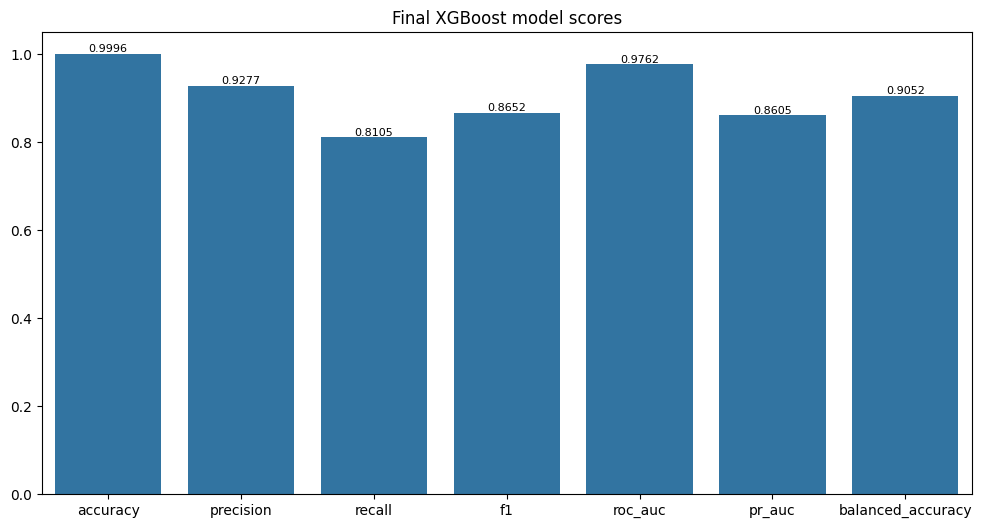

In [72]:
plot_bar_metrics(bst_clf_scores_series,'Final XGBoost model scores')

In [119]:
#saving the XGBoost model
file_path = Path.cwd().parent / 'models' / 'final_XGBoost_model.pkl'
joblib.dump(bst_clf, file_path)

print('model succesfully saved in', file_path)

model succesfully saved in e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\models\final_XGBoost_model.pkl


# 🌲 Random Forest Classifier 

To explore non-linear patterns and potential feature interactions, we train a Random Forest Classifier using all PCA-transformed features and the scaled `Amount` and `Time`.  

Random Forest is a tree-based ensemble method that:  
- Handles imbalanced datasets better than linear models.  
- Provides a direct estimate of feature importances.  

We train the model using 5-fold cross-validation and compute the same evaluation metrics as before.


In [56]:
# ⚙️ Random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',  # Handle class imbalance
    random_state=11037,
    n_jobs=-1
)

# 📊 Evaluate model
rf_cv_results = cross_validate(
    rf_clf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# 📄 Display mean CV scores
for metric, scores in rf_cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.6f}")

results_rand_tree_df = pd.DataFrame(rf_cv_results)


KeyboardInterrupt: 

In [ ]:
results_rand_tree_df = pd.DataFrame(rf_cv_results).mean(numeric_only=True)
results_rand_tree_df.loc['test_accuracy':]

test_accuracy             0.999485
test_precision            0.945307
test_recall               0.732737
test_f1                   0.825389
test_roc_auc              0.938862
test_pr_auc               0.824314
test_balanced_accuracy    0.866333
dtype: float64

In [27]:
plot_bar_metrics(results_rand_tree_df['test_accuracy':])

NameError: name 'plot_bar_metrics' is not defined

In [ ]:
importances = np.mean(
    [estimator.feature_importances_ for estimator in rf_cv_results['estimator']],
    axis=0
)

# 📊 Sort and display
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
feature_importances

v14              0.170655
v10              0.149109
v12              0.128839
v4               0.106788
v11              0.073921
v17              0.064008
v3               0.035334
v16              0.033381
v7               0.032973
v21              0.020764
v2               0.019689
v19              0.013965
v18              0.013449
amount_scaled    0.012271
v20              0.012179
v8               0.010253
v1               0.009849
v5               0.009664
v13              0.009016
v9               0.008683
v15              0.008311
v26              0.008155
v22              0.007096
v6               0.006623
v27              0.006471
v23              0.006432
v25              0.006126
v28              0.006055
time_scaled      0.005304
v24              0.004639
dtype: float64

C:\Users\José Victor\AppData\Local\Temp\ipykernel_17616\1651492526.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")


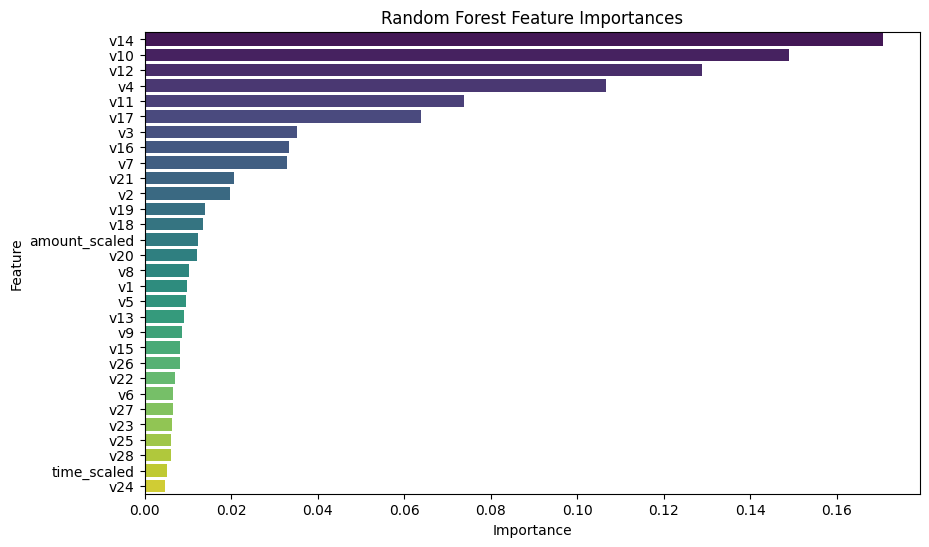

In [ ]:
# 📉 Plot Feature Importances


plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## 🌲 Random Forest Feature Importances

The analysis shows that a small subset of PCA-transformed features (notably V14, V10, V4, V12) carries most of the predictive signal for fraud detection. Features like `amount_scaled` have moderate importance, while `time_scaled` and several PCA features contribute little to model performance.

This suggests that fraud is characterized by patterns concentrated in a few principal components. However, Random Forest’s robustness to irrelevant features allows us to retain all features for now.


In [55]:
# lets try to speed training up by limiting training to top 5
features_to_use = feature_importances.index[:5]

NameError: name 'feature_importances' is not defined

In [ ]:
# 📊 Evaluate model
rf_quick_cv_results = cross_validate(
    rf_clf,
    X_train[features_to_use],
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# 📄 Display mean CV scores
for metric, scores in rf_quick_cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.6f}")

results_quick_rand_tree_df = pd.DataFrame(rf_quick_cv_results)


test_accuracy: 0.999454
test_precision: 0.929168
test_recall: 0.727368
test_f1: 0.815330
test_roc_auc: 0.932688
test_pr_auc: 0.802445
test_balanced_accuracy: 0.863638


In [ ]:
results_quick_rand_tree_df = pd.DataFrame(rf_quick_cv_results).mean(numeric_only=True)
results_quick_rand_tree_df.loc['test_accuracy':]

test_accuracy             0.999454
test_precision            0.929168
test_recall               0.727368
test_f1                   0.815330
test_roc_auc              0.932688
test_pr_auc               0.802445
test_balanced_accuracy    0.863638
dtype: float64

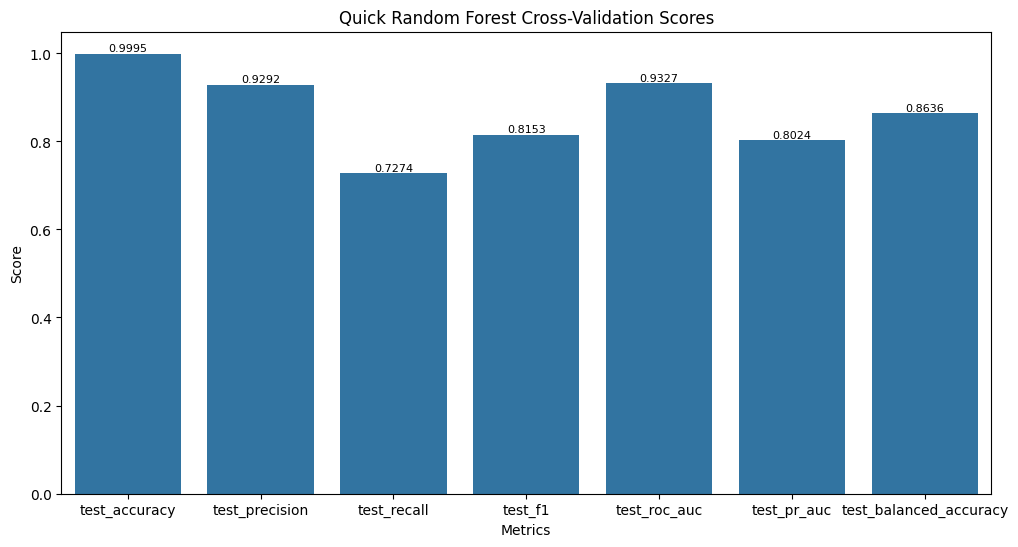

In [ ]:
#plotting the quick version
plt.figure(figsize=(12, 6))

# 📊 Bar plot for Random Forest metrics
quick_rand_tree_scores_barplot = sns.barplot(data=results_quick_rand_tree_df.loc['test_accuracy':])

# Annotate bars with their values
for patch in quick_rand_tree_scores_barplot.patches:
    height = patch.get_height()
    quick_rand_tree_scores_barplot.annotate(
        f'{height:.4f}',  # Format value
        (patch.get_x() + patch.get_width() / 2, height),  # Center annotation
        ha='center', va='bottom', fontsize=8, color='black'
    )

plt.title("Quick Random Forest Cross-Validation Scores")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()


### Hyperparameter tuning with randomized search CV from sklearn


In [54]:


param_dist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", None],
}

rand_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=11037),
    param_distributions=param_dist,
    scoring='aasdad daucprr',
    n_iter=10,
    cv=cv,
    random_state=11037,
    n_jobs=-1
)
rand_search.fit(X_train[features_to_use], y_train)


NameError: name 'features_to_use' is not defined

In [ ]:
print("Best parameters:", rand_search.best_params_)
print("F1_score for top model: ", rand_search.best_score_)

Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None}
F1_score for top model:  0.8204577619229511


In [ ]:
tuned_rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    max_features='sqrt',
    max_depth=None,
    random_state=11037,
    class_weight='balanced',
    n_jobs=-1
)

In [ ]:
# eval the model with CV

tuned_rf_cv_results = cross_validate(
    tuned_rf_model,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

tuned_rf_results = pd.DataFrame(tuned_rf_cv_results).mean(numeric_only=True)

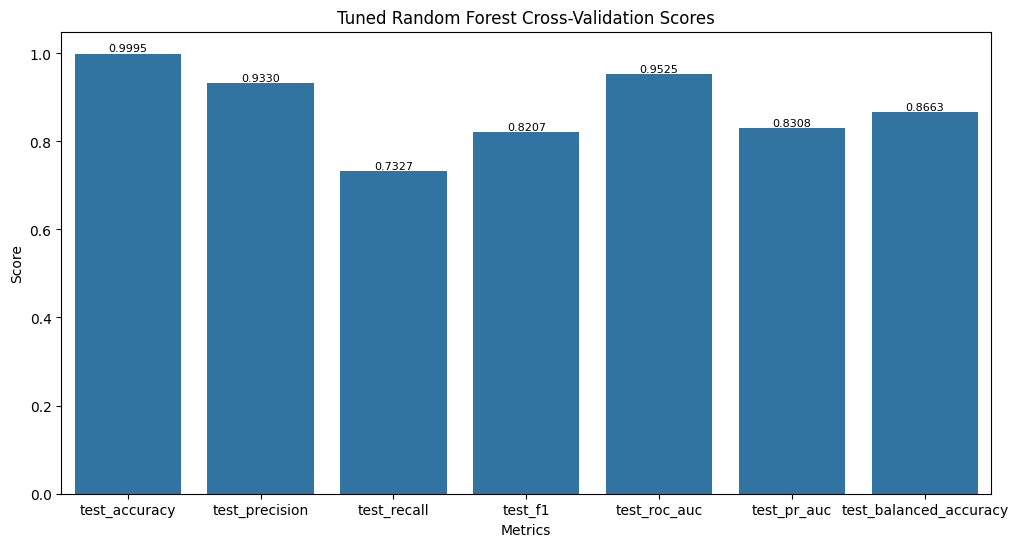

In [ ]:
plt.figure(figsize=(12, 6))

# 📊 Bar plot for Random Forest metrics
rf_tuned_scores_barplot = sns.barplot(data=tuned_rf_results.loc['test_accuracy':])

# Annotate bars with their values
for patch in rf_tuned_scores_barplot.patches:
    height = patch.get_height()
    rf_tuned_scores_barplot.annotate(
        f'{height:.4f}',  # Format value
        (patch.get_x() + patch.get_width() / 2, height),  # Center annotation
        ha='center', va='bottom', fontsize=8, color='black'
    )

plt.title("Tuned Random Forest Cross-Validation Scores")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()

### Now that we have found the best hyperparameters, lets train our *final* model on the whole training data

In [ ]:
final_rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    max_features='sqrt',
    max_depth=None,
    random_state=11037,
    class_weight='balanced',
    n_jobs=-1,
)

In [99]:
# train the model on the training data
final_rf_model.fit(X_train,y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [113]:
filename = Path.cwd().parent / 'models' / 'final_rf_model.pkl'
final_rf_model = joblib.load(filename=filename)

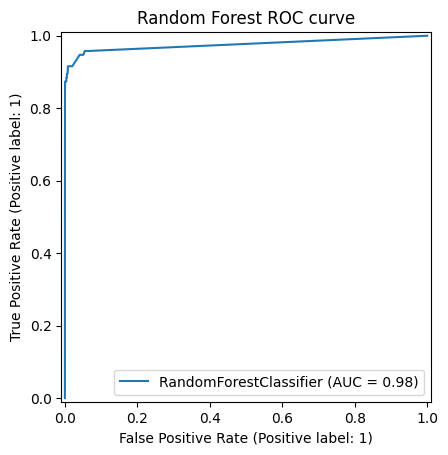

In [195]:
RocCurveDisplay.from_estimator(final_rf_model, X_test, y_test)
plt.title('Random Forest ROC curve')
plt.show()

[[56646     5]
 [   23    72]]


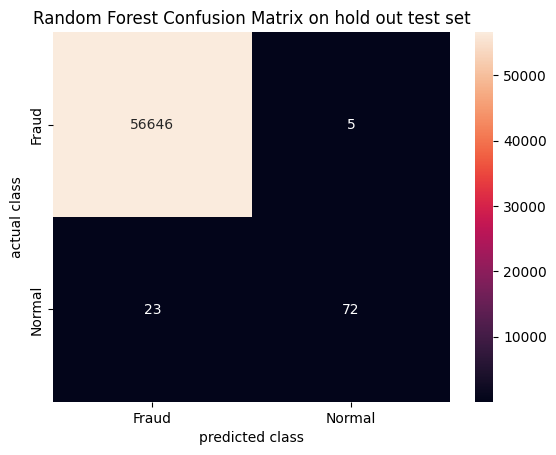

In [192]:
y_pred = final_rf_model.predict(X_test)
def plot_confusion_matrix( y_pred: pd.DataFrame, y_test: pd.DataFrame, title: str):
    final_model_cm = confusion_matrix(y_test,y_pred)
    labels = ['Fraud', 'Normal']

    sns.heatmap(final_model_cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('predicted class')
    plt.ylabel('actual class')
    print(final_model_cm)

plot_confusion_matrix(y_pred, y_test, 'Random Forest Confusion Matrix on hold out test set')

In [116]:
scoring_call = check_scoring(estimator=final_rf_model, scoring=scoring, raise_exc=False)
scores = scoring_call(final_rf_model, X_test, y_test)

In [117]:
scores = pd.Series(scores)

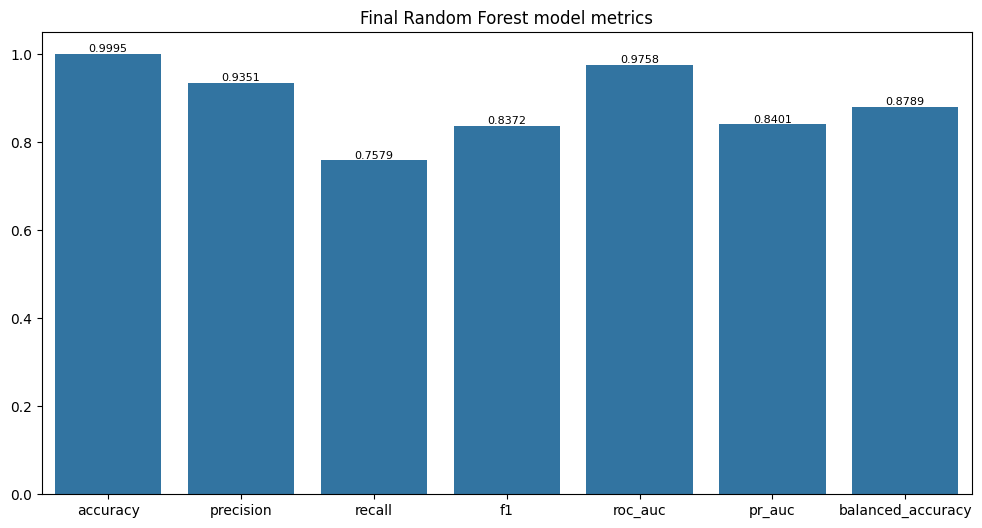

In [118]:
plot_bar_metrics(scores, 'Final Random Forest model metrics')

### finally, saving the final model using joblib

In [ ]:
Path.cwd()

WindowsPath('e:/Programacao/LAPES/EDA_ML_DL_PS/LAPES-Data-Challenge-Predictive-Analytics-System/notebooks')

In [112]:

file_path = Path.cwd().parent / 'models' / 'final_rf_model.pkl'
joblib.dump(final_rf_model, file_path)

print('model succesfully saved in', file_path)

model succesfully saved in e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\models\final_rf_model.pkl


In [205]:
filepath_rf = Path.cwd().parent / 'models' / 'final_rf_model.pkl'
filepath_bst = Path.cwd().parent / 'models' / 'final_XGBoost_model.pkl'
filepath_log = Path.cwd().parent / 'models' / 'logistic_regression_baseline.pkl'

log_clf = joblib.load(filepath_log)
bst_clf = joblib.load(filepath_bst)
final_rf_model = joblib.load(filepath_rf)

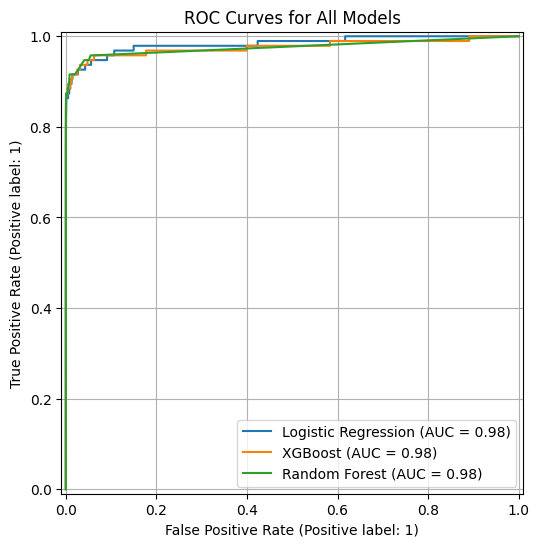

In [212]:
fig, ax = plt.subplots(figsize=(8, 6))


RocCurveDisplay.from_estimator(log_clf, X_test, y_test, ax=ax, name="Logistic Regression")

RocCurveDisplay.from_estimator(bst_clf, X_test, y_test, ax=ax, name="XGBoost")

RocCurveDisplay.from_estimator(final_rf_model, X_test, y_test, ax=ax, name="Random Forest")

ax.set_title("ROC Curves for All Models")
ax.grid(True)

plt.show()
